In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
%matplotlib inline

In [5]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [6]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [7]:
feature_name_residues_dict.keys()

['tm6_tm5_packing',
 'tm6_tm7_packing',
 'rmsd_DRY_inactive',
 'tm6_tm3_dist',
 'rmsd_triad_active',
 'rmsd_triad_inactive',
 'rmsd_npxxy_inactive',
 'rmsd_npxxy_active',
 'rmsd_DRY_active',
 'res_277_res_339_ca_dist',
 'tm6_tm3_packing']

In [8]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.05
rho_string = "_rho0pt05-new"

feature_name = "bp_residues_4dkl_5c1m_unrestricted_pairs_10A"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [9]:
feature_name

'bp_residues_4dkl_5c1m_unrestricted_pairs_10A'

In [10]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
#tica_dir = "%s-with-inactive" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_unrestricted_pairs_10A
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_unrestricted_pairs_10A


In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
user_defined_features_dir = "%s/user_defined_features" %traj_dir
if not os.path.exists(user_defined_features_dir):
    os.makedirs(user_defined_features_dir)
compute_user_defined_features_wrapper(ref_receptors_dir, ".pdb", inactive_dir, active_dir, None,
                                        feature_name_residues_dict, "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5", worker_pool=None, 
                                        save_dir=user_defined_features_dir, parallel=False)

In [11]:
ligand_residue = Residue(resSeq=900, chain_id="L", res_name="LIG")

In [12]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "bu72" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

[u'C6', u'C7', u'C8', u'C9', u'C10', u'C11', u'C23', u'C24', u'C25', u'C26', u'C27', u'C28', u'C1', u'C2', u'N1', u'C3', u'C4', u'C5', u'O1', u'C12', u'C13', u'N2', u'C14', u'O2', u'C15', u'C16', u'C17', u'C18', u'C19', u'C20', u'C21', u'C22']


In [13]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=900, chain_id="L", atom_name=atom_name, res_name="LIG"))

In [14]:
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, bp_residue_objects)]
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [15]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/mor_active_bu72_h8/ionized.pdb"
refined_atom_residue_pairs = compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True)

In [16]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


1023


In [16]:
refined_atom_residue_pairs

[LIG-C6 to TRP318,
 LIG-C6 to CYS321,
 LIG-C6 to ILE322,
 LIG-C6 to ALA323,
 LIG-C6 to LEU324,
 LIG-C6 to GLY325,
 LIG-C6 to TYR326,
 LIG-C6 to LEU232,
 LIG-C6 to LYS233,
 LIG-C6 to VAL236,
 LIG-C6 to PHE237,
 LIG-C6 to ALA240,
 LIG-C6 to PHE241,
 LIG-C6 to CYS292,
 LIG-C6 to TRP293,
 LIG-C6 to THR294,
 LIG-C6 to PRO295,
 LIG-C6 to ILE296,
 LIG-C6 to HIS297,
 LIG-C6 to ILE298,
 LIG-C6 to TYR299,
 LIG-C6 to VAL300,
 LIG-C6 to ILE301,
 LIG-C6 to ILE198,
 LIG-C6 to LEU219,
 LIG-C6 to TYR148,
 LIG-C6 to ASN150,
 LIG-C6 to MET151,
 LIG-C6 to PHE152,
 LIG-C6 to ILE155,
 LIG-C6 to ILE144,
 LIG-C6 to ASP147,
 LIG-C6 to THR120,
 LIG-C6 to GLN124,
 LIG-C7 to TRP318,
 LIG-C7 to CYS321,
 LIG-C7 to ILE322,
 LIG-C7 to ALA323,
 LIG-C7 to LEU324,
 LIG-C7 to GLY325,
 LIG-C7 to TYR326,
 LIG-C7 to LEU232,
 LIG-C7 to LYS233,
 LIG-C7 to ILE234,
 LIG-C7 to CYS235,
 LIG-C7 to VAL236,
 LIG-C7 to PHE237,
 LIG-C7 to ILE238,
 LIG-C7 to PHE239,
 LIG-C7 to ALA240,
 LIG-C7 to PHE241,
 LIG-C7 to CYS292,
 LIG-C7 to T

In [ ]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

In [19]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=refined_atom_residue_pairs, worker_pool=dview, excluded_trajs=["apo", "oxy", "suf"])

NameError: name 'dview' is not defined

In [ ]:
print(features_dir)

In [17]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, feature_residues_pkl, 0.5,
#                             0.1, new_features_file, new_features_pkl, worker_pool=dview)

In [18]:
with open(new_features_pkl) as f:
    new_feature_names = pickle.load(f)
    feature_residues = new_feature_names
print(sorted(new_feature_names))
print(len(new_feature_names))

[Lig900-N1 to Tyr148, Lig900-N1 to Met151, Lig900-N1 to Asp147, Lig900-C3 to Tyr326, Lig900-C3 to Ala117, Lig900-C3 to Tyr148, Lig900-C3 to Asn150, Lig900-C3 to Met151, Lig900-C3 to Asp147, Lig900-C3 to Trp293, Lig900-C4 to Gly325, Lig900-C4 to Tyr326, Lig900-C4 to Ala117, Lig900-C4 to Met151, Lig900-C4 to Asp147, Lig900-C4 to Trp293, Lig900-C5 to Gly325, Lig900-C5 to Tyr326, Lig900-C5 to Ser329, Lig900-C5 to Met151, Lig900-C5 to Asp147, Lig900-C5 to Trp293, Lig900-C5 to Ile296, Lig900-O1 to Trp318, Lig900-O1 to Tyr148, Lig900-O1 to Met151, Lig900-O1 to Lys233, Lig900-O1 to Val236, Lig900-O1 to Phe237, Lig900-O1 to Ala240, Lig900-O1 to Trp293, Lig900-O1 to Ile296, Lig900-O1 to His297, Lig900-O1 to Val300, Lig900-C12 to Tyr148, Lig900-C12 to Met151, Lig900-C12 to Asp147, Lig900-C12 to Ile296, Lig900-C13 to Tyr148, Lig900-C13 to Asp147, Lig900-C13 to Ile296, Lig900-N2 to Tyr148, Lig900-N2 to Ile144, Lig900-N2 to Asp147, Lig900-C14 to Trp318, Lig900-C14 to Ile322, Lig900-C14 to Gln124, Li

In [ ]:
reduced_features = load_file(new_features_file)
df = pd.DataFrame(reduced_features[0], columns=[str(n) for n in new_feature_names])
df["Lig900-N1 to Asp147"]

In [ ]:
sorted(df.columns.values.tolist())

In [19]:
with open(feature_residues_pkl) as f:
    ori_feature_names = pickle.load(f)
print(len(ori_feature_names))

3040


In [ ]:
f = get_trajectory_files(features_dir, ".dataset")[200]
print(f)
x = load_file(f)
df = pd.DataFrame(x, columns=[str(name) for name in refined_atom_residue_pairs])
df["LIG-C15 to Trp318"]

In [21]:
ref_receptors_dir = "/home/enf/md_simulations/MOR/bu72_ref_receptors" 
ref_features_dir = "%s/bu72_ref_receptors" %features_dir
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = new_features_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = new_feature_names, worker_pool=None, schemes=[])

already featurized
already featurized
dihedral_residues:
[]
There are 217 features to be used in featurization.
Saving contact feature residue pairs to disk.
About to featurize trajectories based on the chosen featurization scheme.
[Lig900-C6 to Gly325, Lig900-C6 to Tyr326, Lig900-C6 to Met151, Lig900-C6 to Trp293, Lig900-C6 to Ile296, Lig900-C6 to His297, Lig900-C6 to Val300, Lig900-C7 to Gly325, Lig900-C7 to Tyr326, Lig900-C7 to Asn328, Lig900-C7 to Ser329, Lig900-C7 to Met151, Lig900-C7 to Val236, Lig900-C7 to Ala240, Lig900-C7 to Trp293, Lig900-C7 to Ile296, Lig900-C7 to His297, Lig900-C7 to Val300, Lig900-C8 to Trp318, Lig900-C8 to Gly325, Lig900-C8 to Asn328, Lig900-C8 to Tyr148, Lig900-C8 to Met151, Lig900-C8 to Val236, Lig900-C8 to Ala240, Lig900-C8 to Trp293, Lig900-C8 to Ile296, Lig900-C8 to His297, Lig900-C8 to Val300, Lig900-C9 to Trp318, Lig900-C9 to Gly325, Lig900-C9 to Tyr148, Lig900-C9 to Met151, Lig900-C9 to Lys233, Lig900-C9 to Val236, Lig900-C9 to Ala240, Lig900-C9 t

In [21]:
ref_features_dir

'/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_unrestricted_pairs_10A/bu72_ref_receptors'

In [22]:
import pickle
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [23]:
len(feature_residues)

217

In [ ]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
fit_normalizer(features_dir, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))

In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
if not os.path.exists(ref_features_dir):
    os.makedirs(ref_features_dir)
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))

In [22]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 574.85776768,  469.45840192,  363.79795551,  296.22869439,
        215.06268886,  196.34514685,  136.63151283,  135.47562298,
        109.88948213,  103.9266168 ])

In [23]:
tica_object.components_.shape

(10, 217)

In [24]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(2, 5)
residue_importances_df.shape
(3, 2)
           feature_name       res_i   res_j  importance               feature
1  Lig900-C27 To Val143  Lig900-C27  Val143    2.547524  Lig900-C27 to Val143
0  Lig900-C26 To Val143  Lig900-C26  Val143   -2.119206  Lig900-C26 to Val143
Using dark_background
               residue  importance
Lig900-C27  Lig900-C27    2.547524
Val143          Val143    2.314188
Lig900-C26  Lig900-C26   -2.119206
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(2, 5)
residue_importances_df.shape
(4, 2)
           feature_name       res_i   res_j  importance               feature
1  Lig900-C21 To Tyr128  Lig900-C21  Tyr128    0.664621  Lig900-C21 to Tyr128
0  Lig900-C19 To Tyr326  Lig900-C19  Tyr326   -0.576238  Lig900-C19 to Tyr326
Using dark_background
               residue  importance
Tyr128          Tyr128    0.664621
Lig900-C21  Lig900-C21    0.664621
Tyr326          Tyr326   -0.576238
Lig9

In [25]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [26]:
len(feature_residues)

217

In [27]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print tic_subsampled_features_file
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/features_subsampled.pkl


In [28]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/phi_psi_chi2_allprot_projected.h5"...
(248499, 10)


In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["BU72_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [29]:
bu72_trajs = []
apo_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "bu72" in traj or "CO" in traj or "Co" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [30]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt01"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/"

In [31]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = verboseload(protein_tica_file)
protein_tica_bu72 = [protein_tica[i] for i in bu72_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//phi_psi_chi2_allprot_projected.h5"...


In [32]:
len(bu72_trajs)

512

In [33]:
protein_tica_bu72_conc = np.concatenate(protein_tica_bu72)
ligand_tica_bu72_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/phi_psi_chi2_allprot_projected.h5"...


In [36]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_bu72_conc, ligand_tica_bu72_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["BU72_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [37]:
n_clusters = 1000
clusterer_dir = "%s/bu72clusterer_%dclusters.h5" % (tica_dir, n_clusters)
#cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [ ]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)

In [34]:
import msmbuilder 
reload(msmbuilder)
import msm_resampled
reload(msm_resampled)
from msm_resampled import *

In [35]:
'%s/bu72_clusterer250.h5' %pp_tica_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//bu72_clusterer250.h5'

In [36]:
pp_msm_lag_time=25
pp_n_clusters = 1500
bu72_pp_resampled_traj_to_frames_file = "%s/bu72_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
bu72_pp_resampled_traj_to_frames = verboseload(bu72_pp_resampled_traj_to_frames_file)
bu72_pp_msm_file = "%s/bu72_msm_lag-time%d_prior-counts0.0_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
bu72_pp_msm = verboseload(bu72_pp_msm_file)
bu72_pp_clusterer = verboseload('%s/bu72_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
bu72_pp_clusters_map = make_clusters_map(bu72_pp_clusterer)
bu72_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
bu72_pp_tic_components_dir = "%s" %pp_tica_dir
bu72_pp_tica_dir = bu72_pp_tic_components_dir
bu72_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters))
bu72_pp_pnas_file = "%s/bu72_pnas_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
bu72_pp_pnas = verboseload(bu72_pp_pnas_file)
bu72_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
bu72_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//bu72_msm_lag-time25_prior-counts0.0_clusters1500_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//bu72_msm_lag-time25_prior-counts0.0_clusters1500.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//bu72_clusterer1500.h5"...
0
429
0
0
1
438
0
0
89
651
17
237
418
151
16
0
184
323
350
429
1
1480
0
650
0
310
27
11
0
58
167
20
37
3
663
136
20
10
0
144
0
507
54
1474
5
372
0
30
822
0
11
674
0
298
1
3
0
0
0
1122
0
0
82
15
0
239
0
511
966
1069
0
450
460
312
0
0
0
313
0
39
0
73
296
4
220
0
82
953
0
0
376
212
299
0
5
37
1637
155
1326
796
0
339
0
16
289
53
1
14
427
30
744

In [37]:
pp_msm_lag_time=25
pp_n_clusters = 1500
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//apo_msm_lag-time25_prior-counts0.0_clusters1500_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//apo_msm_lag-time25_prior-counts0.0_clusters1500.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//apo_clusterer1500.h5"...
1
123
393
46
0
1
497
100
160
9
59
0
391
392
7
0
21
817
0
0
1
1284
7
262
184
269
264
20
0
974
2
58
218
104
84
161
27
52
0
1083
153
1812
64
355
261
0
106
20
313
1
235
434
260
343
0
2
131
1
110
973
113
0
1
112
53
0
169
0
1004
182
416
48
161
776
0
0
2
485
0
8
0
33
242
9
253
1
0
95
0
460
7
656
45
0
251
35
0
1
641
0
178
312
0
0
3
615
0
6
458
83
117


In [38]:
pp_analysis_dir = "%s-%sclusters_%dlag-time" %(analysis_dir, pp_n_clusters,pp_msm_lag_time)
analysis_dir = pp_analysis_dir
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

In [43]:
sorted(feature_name_residues_dict.keys())

['res_277_res_339_ca_dist',
 'rmsd_DRY_active',
 'rmsd_DRY_inactive',
 'rmsd_npxxy_active',
 'rmsd_npxxy_inactive',
 'rmsd_triad_active',
 'rmsd_triad_inactive',
 'tm6_tm3_dist',
 'tm6_tm3_packing',
 'tm6_tm5_packing',
 'tm6_tm7_packing']

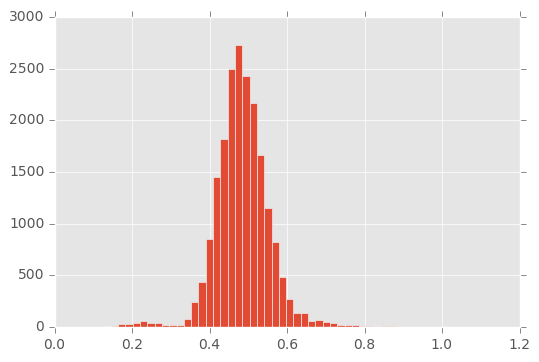

In [44]:
plt.hist(bu72_pp_pnas[:,3], bins=50)
plt.show()

In [39]:
pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
with open(pp_feature_residues_pkl) as f:
    pp_feature_residues = pickle.load(f)
with open(new_features_pkl) as f:
    lp_feature_residues = pickle.load(f)

ref_pp_features = pd.DataFrame(get_features(bu72_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(f) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(bu72_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
ref_lp_tica.columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/5c1m.dataset
(2, 4440)
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_unrestricted_pairs_10A/bu72_ref_receptors/bu72_aligned_4DKL_R_L.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_unrestricted_pairs_10A/bu72_ref_receptors/bu72_ionized_pymol_RL.dataset
(2, 217)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"...


In [47]:
ref_features[["Lig900-C25 to Trp133", "tm6_tm3_packing", "Lig900-N1 to Asp147"]]

,Lig900-C25 to Trp133,tm6_tm3_packing,Lig900-N1 to Asp147
0,7.959673,9.159808,2.517583
1,4.614060,13.017620,2.658068


In [40]:
tica_coords = verboseload(projected_features_dir)
bu72_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
bu72_pnas = verboseload(bu72_pnas_file)
apo_pnas = verboseload(apo_pnas_file)
bu72_tica_file = '%s/bu72_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
bu72_tica = verboseload(bu72_tica_file)
apo_tica = verboseload(apo_tica_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//bu72_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//apo_tica.h5"...


In [41]:
pp_n_components = 10
bu72_pnas_dfs = []
for array in bu72_pnas:
    bu72_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
bu72_tica_dfs = []
for array in bu72_tica:
    bu72_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
lp_tica_dfs = []
for array in tica_coords:
    lp_tica_dfs.append(pd.DataFrame(array, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)]))
bu72_feature_dfs = []
bu72_features = load_file(new_features_file)
print("loaded bu72 features")
for array in bu72_features:
    bu72_feature_dfs.append(pd.DataFrame(array, columns=[str(f) for f in new_feature_names]))
    
pp_n_components = 10
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))



loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_unrestricted_pairs_10A/reduced_features/reduced_features.dataset
loaded bu72 features


In [49]:
len(bu72_feature_dfs)

512

In [42]:
bu72_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/bu72.h5"...
[   1    5   13   17   34   37   41   47   48   59   91   95  101  108  116
  147  166  179  181  191  199  200  201  227  246  251  256  262  267  269
  280  282  288  302  312  315  317  326  332  352  354  386  393  430  461
  471  473  474  476  489  515  518  520  568  585  586  597  606  628  651
  658  659  660  667  668  675  676  689  694  695  724  728  743  747  790
  805  811  814  828  831  841  860  863  874  875  880  881  884  893  894
  899  905  929  935  945  948  952  957  962  964  972  974  983 1008 1014
 1023 1072 1091 1097 1100 1112 1141 1144 1145 1153 1154 1178 1180 1185 1188
 1199 1201 1204 1214 1266 1293 1299 1302 1352 1397 1418 1421 1438 1451 1452
 1466 1484 1497]
[  86  313  481  587  713  779  915 1012 1082 1357 1471]


/home/enf/software/anaconda/lib/python2.7/site-packages/numpy-1.11.0-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [ ]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

In [ ]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] > 0.8)].index.values
msm_intermediate_actives = bu72_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


In [43]:
ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i] for i in apo_trajs]
protein_top_features_bu72 = [protein_top_features[i] for i in bu72_trajs]



loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/features_subsampled.pkl
loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//features_subsampled.pkl


In [52]:
print(len(ligand_top_features))
print(len(protein_top_features_bu72))

512
608


In [44]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
bu72_pp_all_features, bu72_pp_tIC_features = interpret_tIC_components(bu72_pp_projection_operator_dir, bu72_pp_tic_components_dir, bu72_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(5, 5)
residue_importances_df.shape
(6, 2)
           feature_name     res_i     res_j  importance               feature
2  Val66_Ca To Ile69_Ca  Val66_Ca  Ile69_Ca    0.716698  VAL66_CA to ILE69_CA
4  Val66_Ca To Ile71_Ca  Val66_Ca  Ile71_Ca   -0.487056  VAL66_CA to ILE71_CA
3  Thr67_Ca To Ile71_Ca  Thr67_Ca  Ile71_Ca    0.332113  THR67_CA to ILE71_CA
0        Val66 To Thr70     Val66     Thr70    0.258456        VAL66 to THR70
1  Thr67_Ca To Ile69_Ca  Thr67_Ca  Ile69_Ca   -0.229829  THR67_CA to ILE69_CA
Using dark_background
           residue  importance
Ile69_Ca  Ile69_Ca    0.669372
Val66_Ca  Val66_Ca    0.656510
Thr67_Ca  Thr67_Ca    0.304016
Ile71_Ca  Ile71_Ca    0.291155
Thr70        Thr70    0.258456
Val66        Val66    0.258456
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(1, 5)
residue_importances_df.shape
(2, 2)
      feature_name   res_i  res_j  importance          feature
0  Phe338 To Phe84  Phe338

In [71]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [bu72_pp_msm.mapping_[i] for i in active_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
sinks = [bu72_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in bu72_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=50, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

[0, 2, 8, 11, 25, 28, 30, 35, 36, 42, 61, 64, 69, 75, 82, 100, 110, 117, 119, 124, 129, 130, 131, 148, 158, 163, 167, 171, 175, 176, 184, 186, 187, 193, 201, 204, 205, 211, 216, 231, 232, 252, 259, 285, 307, 312, 314, 315, 317, 326, 341, 343, 344, 376, 390, 391, 399, 406, 420, 435, 438, 439, 440, 444, 445, 449, 450, 458, 461, 462, 485, 488, 501, 504, 537, 547, 550, 553, 560, 562, 568, 576, 579, 587, 588, 591, 592, 595, 599, 600, 603, 607, 624, 630, 637, 639, 641, 645, 649, 656, 658, 662, 677, 681, 689, 723, 737, 743, 746, 757, 777, 780, 781, 786, 787, 806, 808, 812, 815, 824, 826, 828, 835, 869, 888, 892, 894, 928, 962, 979, 981, 989, 998, 999, 1009, 1021, 1029]
[58, 202, 319, 392, 477, 528, 614, 679, 731, 931, 1013]
([array([110, 816, 282, 512, 725,  58]), array([216, 816, 282,  68, 308, 477]), array([285, 113, 616, 430, 319]), array([591, 816, 282, 528]), array([ 285,  442,  680,  813, 1030,  430,  319]), array([285, 977, 885, 616, 430, 319]), array([658, 113, 885, 467, 616, 471, 430

In [ ]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [bu72_pp_msm.mapping_[i] for i in tm6_out_clusters if i in bu72_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
bu72_pp_tpt_paths_file = "%s/bu72_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(bu72_pp_msm, sources=sources, sinks=sinks, clusters_map=bu72_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=bu72_pp_tpt_paths_file)

In [ ]:
sources

In [ ]:
inv_tpt_paths

In [45]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
n_steps = 100000
save_file = "%s/msm1000_clusters_t50_%d_steps.h5" % (bu72_pp_tica_dir, n_steps)
msm_traj_index_pairs = generate_msm_traj_index_series(bu72_pp_msm, random.choice(active_clusters.index.values.tolist()), n_steps, bu72_pp_clusters_map, save_file)
msm_traj_index_pairs = verboseload(save_file)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//msm1000_clusters_t50_100000_steps.h5"... (<type 'list'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup//msm1000_clusters_t50_100000_steps.h5"...


In [46]:
projected_features = verboseload(projected_features_dir)
n_clusters=1000
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, bu72_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/tica_msm_lag-time50_clusters1000_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/tica_msm_lag-time50_clusters1000_resampled.h5"...


In [63]:
import os
reload(os)

<module 'os' from '/home/enf/software/anaconda/lib/python2.7/os.pyc'>

In [47]:
bu72_pp_resampled_traj_index_pairs = []
for traj in bu72_pp_resampled_traj_to_frames.keys():
    [bu72_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in bu72_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)*10.
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)*10.
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["BU72 tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(bu72_pp_resampled_traj_index_pairs, bu72_feature_dfs, protein_top_features_bu72, bu72_feature_dfs, bu72_pp_tica, tica_resampled, bu72_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, None, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

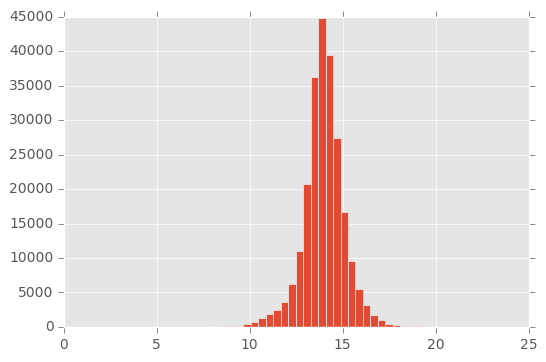

In [48]:
plt.hist(pd.concat(protein_top_features_apo, axis=0)["MET281_CA to MET161_CA"].values*10., bins=50)
plt.show()

In [ ]:
#pm = compute_pearson_matrix(features_eq["tm6_tm3_packing"].values.reshape((-1,1)), features_eq.values).reshape((-1,1))
titles_i = ["tm6_tm3_packing"] + pp_tica_eq.columns.values.tolist() + list(set(pp_features_eq.columns.values.tolist()))
titles_j = list(set(bu72_features_eq.columns.values.tolist())) + bu72_tica_eq.columns.values.tolist()
pm = compute_pearson_matrix(features_eq[titles_i].values, features_eq[titles_j].values)
pmdf = pd.DataFrame(pm, index=titles_i, columns=titles_j)

In [ ]:
pmdf.loc["tm6_tm3_packing"].sort(inplace=False)

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
plt.hexbin(features_eq["Lig900-N1 to Tyr326"], features_eq["tm6_tm3_packing"])

In [ ]:
pmdf.loc[[str(f) for f in bu72_features_eq.columns.values.tolist()]].abs().sort("correlation", ascending=False,inplace=False).iloc[:50].plot(kind='barh')

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau
def hexbin(x, y, color, gridsize=25, n_colors=10, **kwargs):
    cmap = sns.light_palette(color, n_colors=n_colors, as_cmap=True)
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)
    
g = sns.PairGrid(features_eq[["tm6_tm3_packing", "rmsd_npxxy_inactive", "mOR tIC.4", "mOR tIC.6", "(MET281_CA, MET161_CA)", "(Lig900-C19, Gln124)", "(Lig900-C16, Val300)", "(Lig900-C8, Met151)", "(Lig900-N1, Tyr326)"]])# "(GLY82, TYR326)", "(TYR326, ASP147)", "BU72 tIC.3", "(Lig900-N1, Tyr326)", "(Lig900-C4, Tyr326)", "(Lig900-C20, Gln124)", "(Lig900-C6, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(plt.scatter, s=0.1, color="purple")
g.map_lower(plt.scatter, s=0.1, color="purple")

In [49]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in bu72_pp_tIC_features[1]][:5] + ["BU72 tIC.3"] + [str(f) for f in all_tIC_features[2]][:5]
titles_i = ["tm6_tm3_packing"] + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + ["BU72 tIC.%d" %i for i in range(1,n_components+1)]
features_eq_vals = features_eq[titles_i].values
mins = np.min(features_eq_vals, axis=0)
maxs = np.max(features_eq_vals, axis=0)
stds = np.std(features_eq_vals, axis=0)
custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq_vals, analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15, worker_pool=None, parallel=True)

In [ ]:
from jointplot_d3 import *
titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in bu72_pp_tIC_features[1]] + ["mOR tIC.3"] + [str(f) for f in all_tIC_features[2]]
tica_resampled = np.vstack([verboseload(bu72_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq[titles_i], analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15)

In [ ]:
all_tIC_features[0]

In [ ]:
"""
['bu72_reimaged_rep_100.h5', 'bu72_reimaged_rep_119.h5', 'bu72_reimaged_rep_179.h5', 'bu72_reimaged_rep_184.h5', 'bu72_reimaged_rep_186.h5', 'bu72_reimaged_rep_24.h5', 'bu72_reimaged_rep_255.h5', 'bu72_reimaged_rep_27.h5', 'bu72_reimaged_rep_56.h5', 'bu72_reimaged_rep_58.h5', 'bu72_reimaged_rep_59.h5', 'bu72_reimaged_rep_63.h5', 'bu72_reimaged_rep_64.h5', 'bu72_reimaged_rep_83.h5', 'bu72_rep_139.h5', 'bu72_rep_84.h5']"""
bu72_traj_names = [os.path.basename(t) for t in trajs if "bu72" in t]
traj_idx = bu72_traj_names.index('bu72_rep_139.h5')
f = all_traj_features[traj_idx][["tm6_tm3_packing", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]]
#f = protein_ligand_msm_featurized[f.columns.values]
pd.rolling_mean(f[f.columns.values[0]], window=50).plot()

In [ ]:
pd.rolling_mean(f[f.columns.values[1]], window=50).plot()

In [ ]:
pmdf.index.values

In [ ]:
bu72_pp_pnas.T[1,:].shape

In [ ]:
from pandas.tools.plotting import scatter_matrix
#df = pd.concat([pp_features_eq, bu72_features_eq], axis=1)[["(MET281_CA, MET161_CA)", "(Lig900-N1, Tyr326)"] + [str(f) for f in bu72_pp_tIC_features[2][:2] +  all_tIC_features[2][:2]]]
df = features_eq[all_features[0]]
sm = scatter_matrix(df.iloc[::100], figsize=(6, 6), diagonal='kde')
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
plt.show()

In [ ]:
import seaborn as sns



g = sns.PairGrid(features_eq[all_features[0]])
g.map_upper(sns.jointplot, kind="hex", stat_func=kendalltau, color="#4CB391")
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
#g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=5, shade=True, shade_lowest=False)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [50]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
keep_steps = 100000
subsample = 100
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features_bu72, msm_traj_index_pairs[0:keep_steps])
protein_msm_tica_traj = resample_features_by_msm_trajectory(bu72_tica_dfs, msm_traj_index_pairs[0:keep_steps])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(bu72_pnas_dfs, msm_traj_index_pairs[0:keep_steps])
bu72_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:keep_steps])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj*10., protein_msm_featurized_traj*10., protein_msm_tica_traj, protein_msm_pnas_traj, bu72_msm_tica_traj], axis=1)
plmf = protein_ligand_msm_featurized.iloc[::10]

In [51]:
lig_features = list(set([str(g) for l in all_tIC_features for g in l]))
prot_features = list(set([str(g) for l in bu72_pp_tIC_features for g in l]))
f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
#f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
f1 = pd.concat([f*10. for f in protein_top_features_bu72], axis=0)
f2 = pd.concat([f for f in bu72_tica_dfs])
f3 = pd.concat([f for f in bu72_pnas_dfs])
prot_lig_features = pd.concat([f0,f1,f2,f3],axis=1)
all_traj_features = [pd.concat([bu72_feature_dfs[i]*10., protein_top_features_bu72[i]*10., lp_tica_dfs[i], bu72_tica_dfs[i], bu72_pnas_dfs[i]], axis=1) for i in range(0, len(bu72_tica_dfs))]
pm = compute_pearson_matrix(f0[lig_features].values, f1[prot_features].values)
#pmdf = pd.DataFrame(pm, columns=prot_features, index=lig_features)
all_traj_features_apo = [pd.concat([protein_top_features_apo[i]*10., apo_tica_dfs[i], apo_pnas_dfs[i]], axis=1) for i in range(0, len(apo_tica_dfs))]

protein_ligand_msm_featurized = resample_features_by_msm_trajectory(all_traj_features, msm_traj_index_pairs)

In [ ]:
plt.hist(pd.concat(all_traj_features)["Lig1-S1 to His319"], bins=50)

In [ ]:
[n for n in all_traj_features[0].columns.values.tolist() if "319" in n]

In [78]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(bu72_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 9.5)].index.values
msm_intermediate_actives = np.concatenate(bu72_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(bu72_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

0.121917367489
[ 413 1082  263 1151 1135 1263  460  779  481  915  313  713   86 1012  587
 1356]


In [ ]:
plt.hist(all_traj_features[0]["Lig900-N1 to Asp147"].values, bins=50)
plt.show()

In [ ]:
t = md.load_frame(get_trajectory_files(traj_dir, ".h5")[0], index=1)
keep = [a.index for a in t.topology.atoms if a.residue.is_protein or "LIG" in str(a.residue)]
t2 = t.atom_slice(keep)
t2.save("/home/enf/test11.pdb")

In [ ]:
get_trajectory_files(features_dir, ".dataset")[100]

In [ ]:
co_trajs = [i for i in range(0,len(all_traj_features)) if "Co" in get_trajectory_files(traj_dir, ".h5")[i]]

In [ ]:
f.shape

In [ ]:
f = load_file("/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A/Rep_Co_BU0-0.dataset")
fdf = pd.DataFrame(f, columns=ori_feature_names)

In [ ]:
msm_intermediate_actives

In [ ]:
plt.clf()
plt.hist(cluster_features_averages["PHE289 to ASN150"].dropna().values, bins=50)
plt.show()

In [ ]:
cluster_features_averages["tm6_tm3_packing"].dropna().shape

In [ ]:
plt.clf()
plt.hist(apo_features_eq["tm6_tm3_packing"], bins=50)
plt.show()

In [ ]:

all_traj_features_np = [f.values for f in all_traj_features_apo]

cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = np.concatenate(apo_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(apo_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(apo_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

In [ ]:
all_traj_features_np[3]

In [ ]:

prot_features = list(set([str(g) for l in bu72_pp_tIC_features for g in l]))
f1 = pd.concat([f*10. for f in protein_top_features_apo], axis=0)
f2 = pd.concat([f for f in apo_tica_dfs])
f3 = pd.concat([f for f in apo_pnas_dfs])
prot_lig_features = pd.concat([f1,f2,f3],axis=1)



all_traj_features_np = [f.values for f in all_traj_features_apo]
cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["PHE338 to PHE84"] > 16.) & (cluster_features_averages["tm6_tm3_packing"] > 0.)].index.values
msm_intermediate_actives = apo_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(bu72_pp_msm.populations_[msm_intermediate_actives])
print(bu72_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

In [ ]:
tpt_paths_features[6]["Lig900-N1 to Tyr326"]

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 9.5) & (cluster_features_averages["(PHE156, SER196)"] < 10.5)].index)
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 6.) & (cluster_features_averages["(PHE156, SER196)"] < 7.)].index)

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 11.) & (cluster_features_averages["(ASP114, TYR336)"] > 8.)& (cluster_features_averages["(Lig900-C19, Ile322)"] > 5.)].index)

In [ ]:
plt.hist(features_eq["Lig900-N1 to Tyr326"], bins=200)
plt.show()

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["mOR tIC.6"] > 4.)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(VAL89_CA, TYR336_CA)"] >11.5)].index

In [ ]:
g = sns.PairGrid(prot_lig_features[["tm6_tm3_packing", "tIC.3", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(hexbin, color="purple", n_colors=30, gridsize=30)
g.map_lower(plt.scatter, s=.1)

In [ ]:
protein_top_features[0].iloc[::3]

In [ ]:
import seaborn as sns

In [ ]:
pmdf

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
prot_lig_features.plot(kind='scatter', x="(MET281_CA, MET161_CA)", y= "(Lig900-C10, Val236)")

In [ ]:
plmf.columns.values

In [58]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(tica_resampled, bu72_pp_tica, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/rfr_importances.h5" %analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/analysis_n_clusters1000_random-1500clusters_25lag-time/rfr_r2_scores.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/analysis_n_clusters1000_random-1500clusters_25lag-time/rfr_importances.h5"...


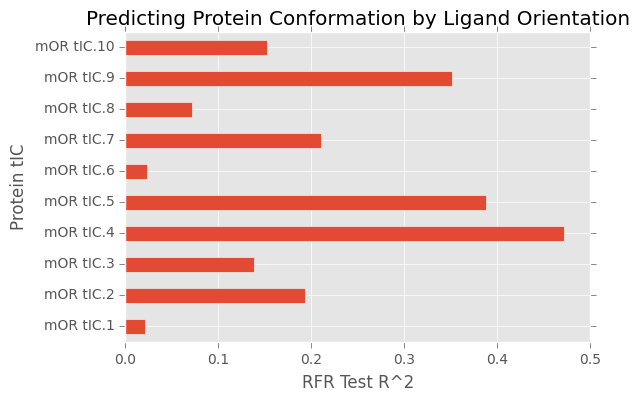

In [59]:
r2_scores_df = pd.Series(r2_scores, index=["mOR tIC.%d" %i for i in range(1, len(r2_scores)+1)])
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein tIC")
plt.savefig("%s/%s.pdf" %(analysis_dir, title))
plt.show()

In [79]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
#pd.concat([pp_features_eq, bu72_features_eq, pp_tica_eq, bu72_tica_eq, bu72_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, bu72_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)

y = pd.concat([features_eq[protein_top_features[0].columns], features_eq[sorted(feature_name_residues_dict.keys())], features_eq[["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]]],axis=1)
x = features_eq[[str(f) for f in new_feature_names]]

if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/analysis_n_clusters1000_random-1500clusters_25lag-time/all_features_rfr_r2_scores.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/analysis_n_clusters1000_random-1500clusters_25lag-time/all_features_rfr_importances.h5"...


In [92]:
r2_scores_df = pd.Series(r2_scores, index=y.columns)
r2_scores_df = r2_scores_df[[n for n in y.columns.values.tolist() if "dist" not in n]]
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.sort(inplace=False).plot(kind='barh', title=title, figsize=(4,10))
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein Feature")
plt.savefig("%s/all_features_%s.pdf" %(analysis_dir, title))

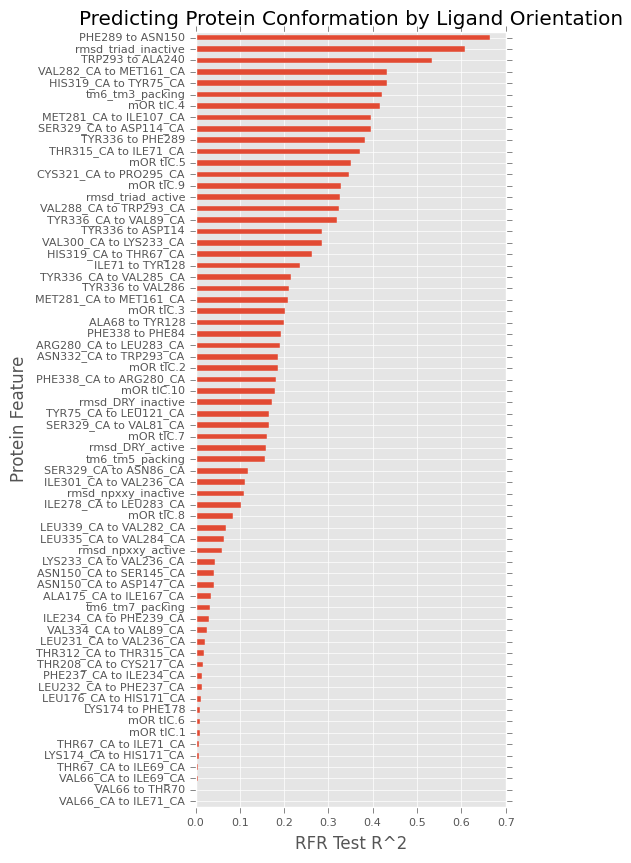

In [93]:
plt.show()

In [ ]:
r2_scores_df["tm6_tm3_packing"]

In [ ]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

In [ ]:
importances_df = pd.DataFrame(importances, columns=y.columns, index=x.columns)
importances_df["tm6_tm3_packing"].abs().sort(inplace=False, ascending=False).iloc[:30]



/home/enf/software/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/enf/software/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


[ 0 11 13 19 33 37 39 40 41 46 47 54 55 57 63 64 68]
[149, 1, 130, 4, 6, 7, 8, 9, 10, 139, 12, 13, 14, 141, 145, 19, 20, 21, 23, 24, 25, 30, 31, 33, 35, 36, 177, 41, 42, 44, 49, 50, 179, 180, 186, 187, 188, 61, 192, 67, 78, 79, 208, 210, 164, 144, 107, 110, 124, 170, 127]
17


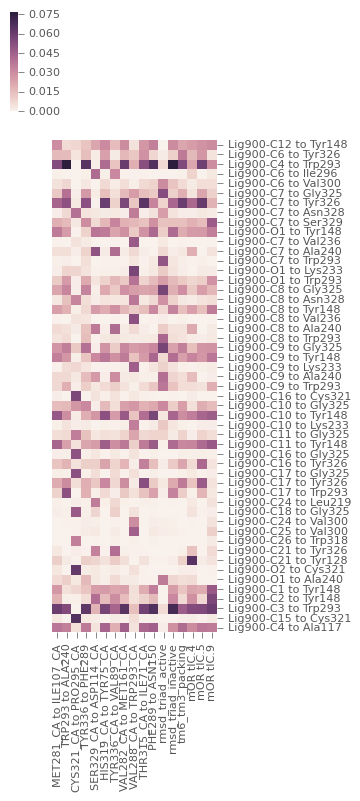

'\n\nplot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method=\'average\', z_score=None)\n\n\n\nfig = plt.figure()\nax = fig.add_subplot(111)\nheatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)\n\n# put the major ticks at the middle of each cell\nax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)\nax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)\n\n# want a more natural, table-like display\n#ax.invert_yaxis()\n#ax.xaxis.tick_top()\n\nax.set_xticklabels(row_labels, minor=False, rotation=270)\nax.set_yticklabels(column_labels, minor=False)\nfig.subplots_adjust(bottom=0.2)\n\nfig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format=\'svg\', dpi=1200)\nplot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir\npp = PdfPages(plot_file)\n\npp.savefig(fig)\n\npp.close()  \nplt.show()\n'

In [82]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()
plt.clf()
#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

responses_to_keep = np.where(np.array(r2_scores) > 0.3)[0]
importances_scaled = importances_scaled[:,responses_to_keep]
predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
print(responses_to_keep)
print(predictors_to_keep)
importances_scaled = importances_scaled[predictors_to_keep,:]
print(len(responses_to_keep))

#row_labels = ["BU72 tIC.%d" %i for i in range(1, n_components+1)]
#column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
row_labels = x.columns.values[predictors_to_keep]
column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/bu72_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/bu72_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [ ]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

r2_scores

In [77]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=2, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["BU72 tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_BU72_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=8., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=8., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=8., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)


bu72_jointplots_refcoords_dir = "%s/bu72_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(bu72_jointplots_refcoords_dir):
    os.makedirs(bu72_jointplots_refcoords_dir)
    
all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=5, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[5 7 4 3 1 2 8 0 6 9]
mOR tIC.1
Creating joint deltaG plots.
(19953, 11)
(19953, 9)
(2, 11)
(2, 9)
Making delta G plots.
Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-2.57717773  0.35456543]
 [-0.2671376   0.03860973]][[  9.15980816   0.35456543]
 [ 13.01761985   0.03860973]][[ 0.6414

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
4
4
4
4
4
4
i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-2.57717773  2.51758337]
 [-0.2671376   2.65806818]][[  9.15980816   2.51758337]
 [ 13.01761985   2.65806818]][[ 0.64148617  2.51758337]
 [ 0.          2.65806818]][[ 0.          2.51758

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
7
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19953)
Computed Density. Now plotting.



Computed 2D KDE

(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)min_density=0.0(0.0, 8.0)





[[-2.57717773  3.83722496]
 [-0.2671376   3.35832787]][[  9.15980816   8.93306351]
 [ 13.01761985   6.18403959]][[ 0.64148617  9.28451443]
 [ 0.          9.20263004]][[  0.          10.90048313]
 [  0.64148796  16.76941299]]Computed Density. Now plotting.
[[  3.83722496  11.37884331]
 [  3.35832787   8.582757  ]]



(0.0, 8.0)
6789
8



[[ 8.93306351  9.28451443]
 [ 6.18403959  9.20263004]]
(2, 19953)
(2, 19953)
(2, 19953)
10

(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)
8Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE

min_densit

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.35456543  0.        ]
 [ 0.03860973  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 7.16512203  0.        ]
 [ 4.49256039  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 2.51758337  0.        ]
 [ 2.65806818  0.64148796]][[ 5.38001442  0.        ]
 [ 5.07479     0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-2.57717773  5.1002841 ]
 [-0.2671376   4.68973684]][[  9.15980816   5.1002841 ]
 [ 13.01761985   4.68973684]][[ 0.64148617  5.1002841 ]
 [ 0.          4.68973684]][[ 0.          5.1002841 ]
 [ 0.64148796  4.68973684]][[ 6.95101023  5.1002841 ]
 [ 6.25163794  4.68973684]][[ 3.83722496  5.1002841 ]
 [ 3.35832787  4.68973684]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
7
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19953)
Computed Density. Now plotting.



Computed 2D KDE

(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)min_density=0.0(0.0, 8.0)





[[-2.57717773  3.83722496]
 [-0.2671376   3.35832787]][[  9.15980816   8.93306351]
 [ 13.01761985   6.18403959]][[ 0.64148617  9.28451443]
 [ 0.          9.20263004]][[  0.          10.90048313]
 [  0.64148796  16.76941299]]Computed Density. Now plotting.
[[  3.83722496  11.37884331]
 [  3.35832787   8.582757  ]]



(0.0, 8.0)
6789
8



[[ 8.93306351  9.28451443]
 [ 6.18403959  9.20263004]]
(2, 19953)
(2, 19953)
(2, 19953)
10

(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)
8Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE

min_densit

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.1666936   0.        ]
 [-1.22081546  0.64148796]][[ 4.76301527  0.        ]
 [ 3.75602913  0.64148796]][[ 7.42176819  0.        ]
 [ 6.49873209  0.64148796]][[ 5.1002841   0.        ]
 [ 4.68973684  0.64148796]][[  9.50248051   0.        ]
 [ 12.98243904   0.64148796]][[ 6.14742088  0.        ]
 [ 9.04805756  0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


Computed Density. Now plotting.




i=5

i=4
i=3
i=2
i=0
i=1
j=2
(0.0, 8.0)j=2
j=2
j=2
j=2
j=2
(19953, 10)

(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 9)
[[ 7.3063798   9.28451443]
 [ 6.38203526  9.20263004]](19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)

(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
8Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
i=10





(0.0, 8.0)j=8
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)
(19953, 12)





[[ 5.9295125   7.16512203]
 [ 9.7176075   4.49256039]](19953, 11)
[[ 5.9295125   7.16512203]
 [ 9.7176075   4.49256039]][[ 0.          7.16512203]
 [ 0.64148796  4.49256039]][[ 0.64148617  7.16512203]
 [ 0.          4.49256039]][[ 0.17776327  7.16512203]
 [-0.0751468

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
9Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

min_density=0.0Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19953)





Computed 2D KDE
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)Computed Density. Now plotting.(0.0, 8.0)





[[ 0.17776327  5.61469364]
 [-0.07514686  6.64069271]][[  9.15980816   8.39526081]
 [ 13.01761985  10.54314613]][[ 0.64148617  8.44507885]
 [ 0.          8.60399818]][[ 0.          5.13342762]
 [ 0.64148796  5.17386532]](0.0, 8.0)[[ 8.44507885  5.13342762]
 [ 8.60399818  5.17386532]]





789[[  8.39526081   5.13342762]
 [ 10.54314613   5.17386532]]



(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.


(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)


[[  0.1

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

3





3i=0
i=1
i=2
i=3
i=4

j=3
j=3
j=3
j=3
j=3
i=5
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
j=3
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(19953, 10)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE





Computed Density. Now plotting.(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





(0.0, 8.0)[[ 0.35456543  0.        ]
 [ 0.03860973  0.64148796]][[ 5.38001442  0.        ]
 [ 5.07479     0.64148796]][[ 7.16512203  0.        ]
 [ 4.49256039  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 2.51758337  0.        ]
 [ 2.65806818  0.64148796]]





[[ 5.38001442  0.        ]
 [ 5.07479     0.64148796]]44444





4i=0
i=1
i=2
i=3
i=4

j=4
j=4
j=4
j=4
j=4
i=5

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.17776327  3.47688222]
 [-0.07514686  3.91390896]][[  9.15980816   3.47688222]
 [ 13.01761985   3.91390896]][[ 0.64148617  3.47688222]
 [ 0.          3.91390896]][[ 0.          3.47688222]
 [ 0.64148796  3.91390896]][[  8.39526081   3.47688222]
 [ 10.54314613   3.91390896]][[ 5.9295125   3.47688222]
 [ 9.7176075   3.91390896]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.min_density=0.0

Computed Density. Now plotting.Computed Density. Now plotting.

(0.0, 8.0)(0.0, 8.0)

(0.0, 8.0)Computed Density. Now plotting.


(0.0, 8.0)(0.0, 8.0)
(0.0, 8.0)[[ 0.17776327  5.9295125 ]
 [-0.07514686  9.7176075 ]][[  9.15980816   5.61469364]
 [ 13.01761985   6.64069271]]

[[  8.39526081   5.13342762]
 [ 10.54314613   5.17386532]]


[[ 0.64148617  8.44507885]
 [ 0.          8.60399818]][[ 0.          5.13342762]
 [ 0.64148796  5.17386532]]
[[  5.61469364   8.39526081]
 [  6.64069271  10.54314613]]67

8


9
8(2, 19953)
8


9
Computed 2D KDE
(2, 19953)
(2, 19953)
(2, 19953)
9
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)

Computed Density. Now plotting.Computed Density. Now plotting.Computed Densit

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.32475649  0.        ]
 [ 1.29960724  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 12.63677692   0.        ]
 [ 11.81252003   0.64148796]][[ 3.47688222  0.        ]
 [ 3.91390896  0.64148796]][[ 6.14742088  0.        ]
 [ 9.04805756  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
4
4
4
4
4
4
i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-1.90337107  2.51758337]
 [-0.13612045  2.65806818]][[  9.15980816   2.51758337]
 [ 13.01761985   2.65806818]][[ 0.64148617  2.51758337]
 [ 0.          2.65806818]][[ 0.          2.51758

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)
8Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE

Computed Density. Now plotting.


Computed Density. Now plotting.(2, 19953)

(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)
Computed 2D KDE
(0.0, 8.0)


(0.0, 8.0)Computed Density. Now plotting.
[[-1.90337107  8.48440075]
 [-0.13612045  8.43546963]][[  9.15980816   5.2640419 ]
 [ 13.01761985   5.52275133]][[ 0.64148617  8.61951733]
 [ 0.          9.95550251]]

[[ 8.48440075  4.99150467]
 [ 8.43546963  4.61715651]]


[[  0.           7.22647715]
 [  0.64148796  11.89021683]](0.0, 8.0)
678

11


10[[ 5.2640419   8.32204056]
 [ 5.52275133  8.12411022]]
(2, 19953)
(2, 19953)
9


(2, 19953)
Computed 2D KDE
Computed 2D KDE
(2, 19953)
(2, 19953)
9Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.

Computed Density. Now plot

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.35456543  0.        ]
 [ 0.03860973  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 7.16512203  0.        ]
 [ 4.49256039  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 2.51758337  0.        ]
 [ 2.65806818  0.64148796]][[ 5.38001442  0.        ]
 [ 5.07479     0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-1.90337107  5.23685074]
 [-0.13612045  5.27934599]][[  9.15980816   5.23685074]
 [ 13.01761985   5.27934599]][[ 0.64148617  5.23685074]
 [ 0.          5.27934599]][[ 0.          5.23685074]
 [ 0.64148796  5.27934599]][[ 8.61951733  5.23685074]
 [ 9.95550251  5.27934599]][[ 8.48440075  5.23685074]
 [ 8.43546963  5.27934599]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


(2, 19953)
Computed 2D KDE
Computed 2D KDE
(2, 19953)
(2, 19953)
9Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.

Computed Density. Now plotting.Computed Density. Now plotting.(2, 19953)

(0.0, 8.0)(0.0, 8.0)

Computed 2D KDE
(0.0, 8.0)

(0.0, 8.0)(0.0, 8.0)Computed Density. Now plotting.
[[-1.90337107  8.48440075]
 [-0.13612045  8.43546963]][[  9.15980816   5.2640419 ]
 [ 13.01761985   5.52275133]]


[[ 8.48440075  4.99150467]
 [ 8.43546963  4.61715651]]

[[ 0.64148617  8.32204056]
 [ 0.          8.12411022]][[  0.           7.22647715]
 [  0.64148796  11.89021683]](0.0, 8.0)
67


11

910[[  5.2640419    7.22647715]
 [  5.52275133  11.89021683]]
(2, 19953)
8



(2, 19953)
Computed 2D KDE
(2, 19953)
(2, 19953)
(2, 19953)
10Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.
Computed Density. Now plotting.Computed De

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(19953, 13)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.70471608  0.        ]
 [ 0.89881412  0.64148796]][[ 6.67084742  0.        ]
 [ 5.1706686   0.64148796]][[ 12.63677692   0.        ]
 [ 11.81252003   0.64148796]][[ 5.23685074  0.        ]
 [ 5.27934599  0.64148796]][[  9.33519554   0.        ]
 [ 10.03596687   0.64148796]][[ 6.67084742  0.        ]
 [ 5.1706686   0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.01243004  8.21646404]
 [-0.25917122  9.20012379]][[  9.15980816   8.21646404]
 [ 13.01761985   9.20012379]][[ 0.64148617  8.21646404]
 [ 0.          9.20012379]][[ 0.          8.21646404]
 [ 0.64148796  9.20012379]][[ 4.59303713  8.21646404]
 [ 3.40877271  9.20012379]][[ 4.59303713  8.21646404]
 [ 3.40877271  9.20012379]]





00000




i=6
i=7
i=10
i=8
i=9
j=0
j=0
j=0
j=0
j=0
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 4)
(19953, 4)
(19953, 4)
(19953, 4)
(19953, 4)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0




Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

8(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE





min_density=0.0(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





Computed Density. Now plotting.
[[ 4.59303713  8.49121094]
 [ 3.40877271  8.66649532]][[ -0.01243004   8.67575741]
 [ -0.25917122  12.20886421]][[  9.15980816   8.35674095]
 [ 13.01761985   8.3526001 ]][[ 0.64148617  8.68623924]
 [ 0.          8.3781929 ]][[  0.          11.97524643]
 [  0.64148796   9.53797245]](0.0, 8.0)





978910[[ 8.35674095  8.68623924]
 [ 8.3526001   8.3781929 ]]





(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
9Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

min_density=0.0Computed Density. Now plotting.Computed Density. Now plot

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.01243004  0.83216318]
 [-0.25917122 -0.32134962]][[  9.15980816   0.83216318]
 [ 13.01761985  -0.32134962]][[ 0.64148617  0.83216318]
 [ 0.         -0.32134962]][[ 0.          0.83216318]
 [ 0.64148796 -0.32134962]][[ 4.59303713  0

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.01243004  6.98645401]
 [-0.25917122  6.57012987]][[  9.15980816   6.98645401]
 [ 13.01761985   6.57012987]][[ 0.64148617  6.98645401]
 [ 0.          6.57012987]][[ 0.          6.98645401]
 [ 0.64148796  6.57012987]][[ 4.59303713  6.98645401]
 [ 3.40877271  6.57012987]][[ 4.59303713  6.98645401]
 [ 3.40877271  6.57012987]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

8(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19953)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE





min_density=0.0(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





Computed Density. Now plotting.
[[ 4.59303713  8.49121094]
 [ 3.40877271  8.66649532]][[ -0.01243004   8.67575741]
 [ -0.25917122  12.20886421]][[  9.15980816   8.35674095]
 [ 13.01761985   8.3526001 ]][[ 0.64148617  8.68623924]
 [ 0.          8.3781929 ]][[  0.          11.97524643]
 [  0.64148796   9.53797245]](0.0, 8.0)





978910[[ 8.35674095  8.68623924]
 [ 8.3526001   8.3781929 ]]





(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
9Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

min_density=0.0Computed Density. Now plotting.Computed Density. Now plot

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(19953, 11)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.83216318  0.        ]
 [-0.32134962  0.64148796]][[ 7.36683178  0.        ]
 [ 6.08405638  0.64148796]][[ 9.30021477  0.        ]
 [ 7.83000994  0.64148796]][[ 6.98645401  0.        ]
 [ 6.57012987  0.64148796]][[ 7.95967293  0.        ]
 [ 4.61405993  0.64148796]][[ 8.42429924  0.        ]
 [ 7.91720819  0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.01704721  5.35800886]
 [-0.58263835  4.12458277]][[  9.15980816   5.35800886]
 [ 13.01761985   4.12458277]][[ 0.64148617  5.35800886]
 [ 0.          4.12458277]][[ 0.          5.35800886]
 [ 0.64148796  4.12458277]][[ 12.54730225   5.35800886]
 [  6.49738598   4.12458277]][[ 12.54730225   5.35800886]
 [  6.49738598   4.12458277]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
mOR tIC.5
Creating joint deltaG plots.
(19953, 6)
(19953, 6)
(2, 6)
(2, 6)
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.35456543  1.01704721]
 [ 0.03860973 -0.58263835]][[ 5.50349522  1.01704721]
 [ 5.21251917 -0.58263835]][[ 7.16512203  1.01704721]
 [ 4.49256039 -0.58263835]][[ 5.358008

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.35456543  0.        ]
 [ 0.03860973  0.64148796]][[ 5.50349522  0.        ]
 [ 5.21251917  0.64148796]][[ 7.16512203  0.        ]
 [ 4.49256039  0.64148796]][[ 5.35800886  0.        ]
 [ 4.12458277  0.64148796]][[ 2.51758337  0.        ]
 [ 2.65806818  0.64148796]][[ 5.38001442  0.        ]
 [ 5.07479     0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(1

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
4
4
4
4
4
4
i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[  1.01704721   9.33519554]
 [ -0.58263835  10.03596687]][[  9.15980816   9.33519554]
 [ 13.01761985  10.03596687]][[  0.64148617   9.33519554]
 [  0.          10.03596687]][[  0.           9.3351955

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.70471608  1.01704721]
 [ 0.89881412 -0.58263835]][[ 5.23685074  1.01704721]
 [ 5.27934599 -0.58263835]][[ 12.63677692   1.01704721]
 [ 11.81252003  -0.58263835]][[ 5.23685074  1.01704721]
 [ 5.27934599 -0.58263835]][[  9.33519554   1.01704721]
 [ 10.03596687  -0.58

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(19953, 6)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.70471608  0.        ]
 [ 0.89881412  0.64148796]][[ 5.23685074  0.        ]
 [ 5.27934599  0.64148796]][[ 12.63677692   0.        ]
 [ 11.81252003   0.64148796]][[ 5.23685074  0.        ]
 [ 5.27934599  0.64148796]][[  9.33519554   0.        ]
 [ 10.03596687   0.64148796]][[ 6.67084742  0.        ]
 [ 5.1706686   0.64148796]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=

In [ ]:
protein_ligand_msm_featurized.columns.values.tolist()

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=15, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    bu72_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(bu72_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            #if "tm" not in str(features_i[prot_idx]): continue
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                else:
                    refcoords = None
                    refcoords_j = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=np.hstack([refcoords, refcoords_j]), refcoords_j=ref_df[custom_features[0]].values, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

Creating joint deltaG plots.
(19953, 1)
(19953, 15)
(2, 1)
(2, 15)
Making delta G plots.


In [102]:
def convert_lig_name(df, old_lig_name, new_lig_name):
    names = df.columns.values.tolist()
    for i, name in enumerate(names):
        if old_lig_name in str(name):
            names[i] = "%s-" %new_lig_name + name[7:]
    df.columns = names
    return df

In [ ]:
dfdf

we are operating on biox3


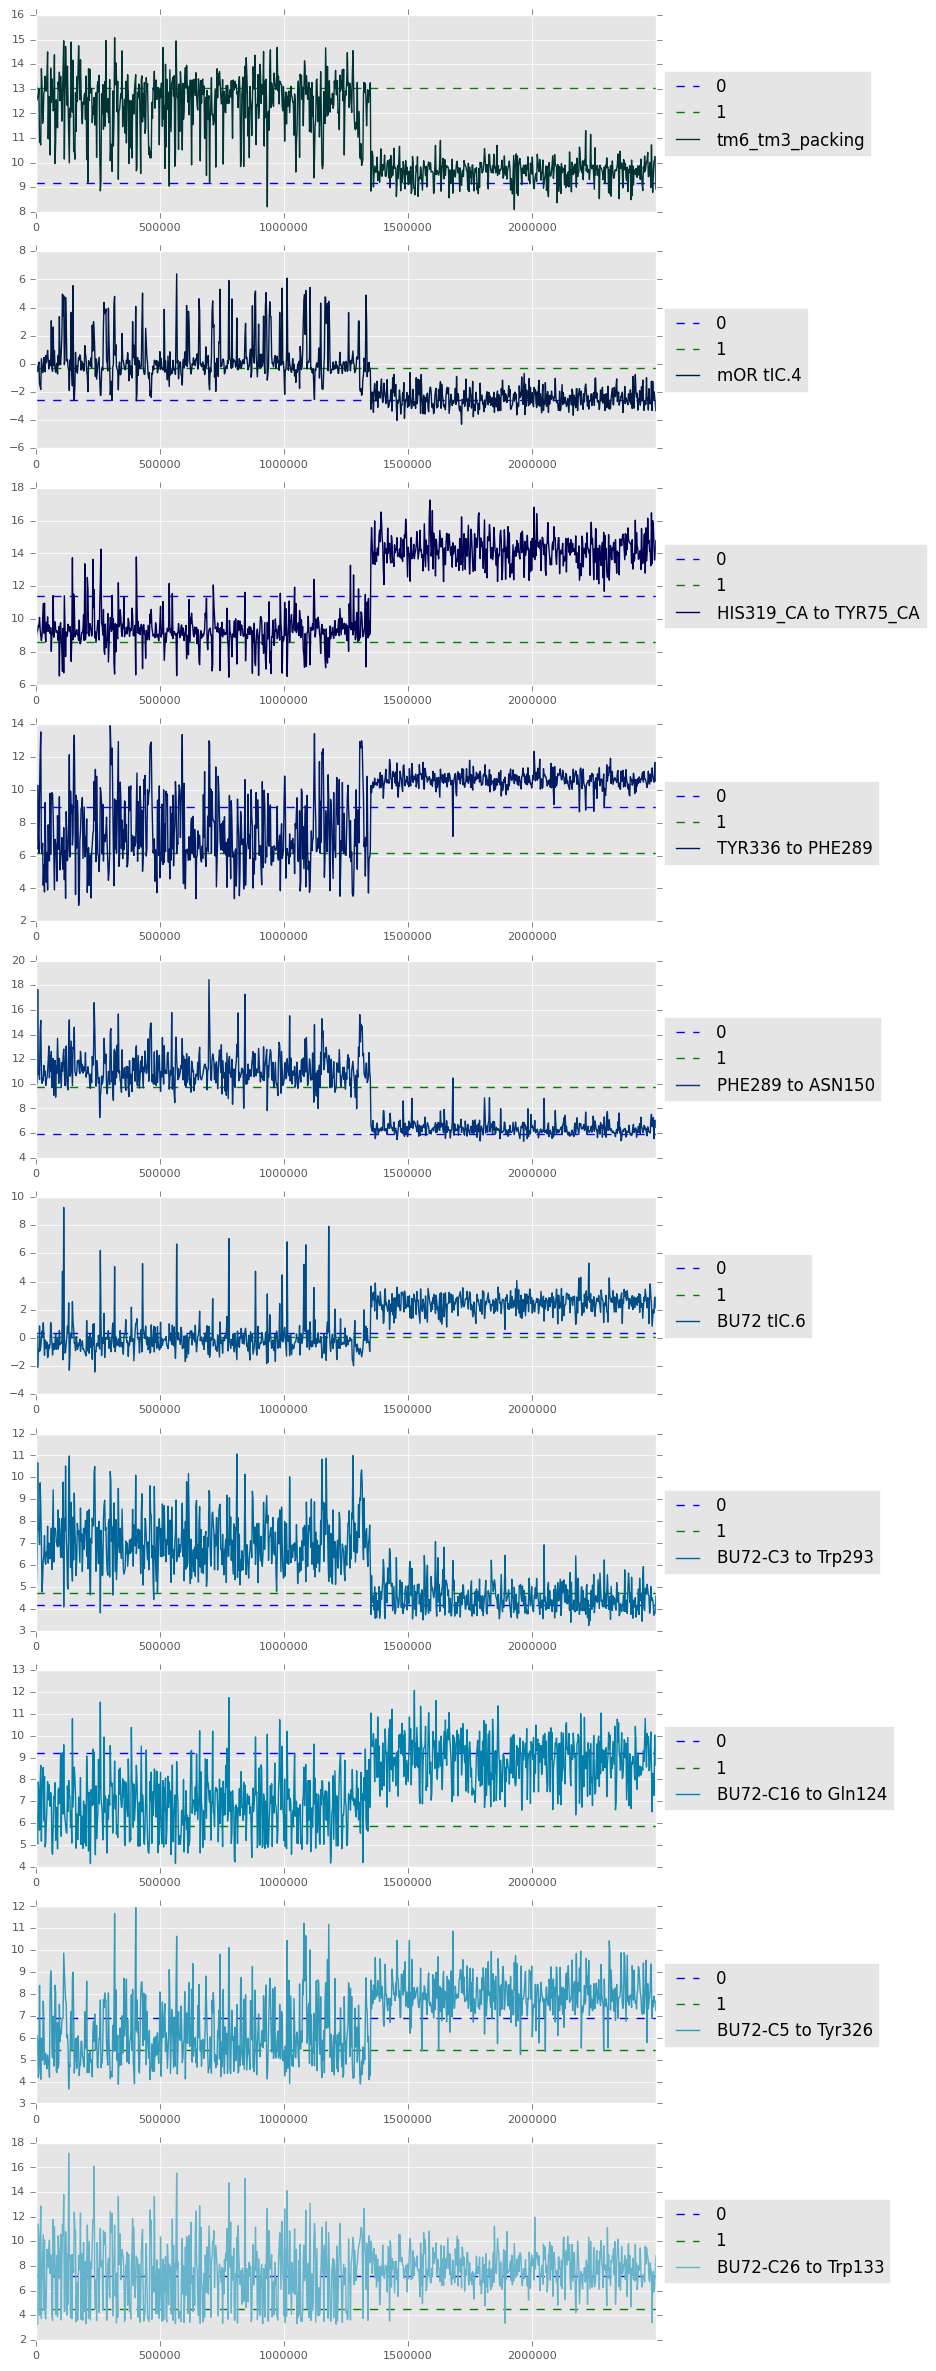

In [131]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=1
plmf = convert_lig_name(plmf, "Lig900", "BU72")
ref_df = convert_lig_name(ref_features, "Lig900", "BU72")
plot_features = ["tm6_tm3_packing", "mOR tIC.4", "HIS319_CA to TYR75_CA", "TYR336 to PHE289", "PHE289 to ASN150", "BU72 tIC.6", "BU72-C3 to Trp293", "BU72-C16 to Gln124", "BU72-C5 to Tyr326", "BU72-C26 to Trp133"]
plot_df = plmf[plot_features]
plot_df.index *= pp_msm_lag_time
plt.clf()
plot_df_rolling(plot_df.iloc[::100], "%s/key_measurements_tIC4.png" %analysis_dir, True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None, ref_df=ref_df)
plt.show()

In [126]:
plmf.columns.values.tolist()

['BU72-C6 to Gly325',
 'BU72-C6 to Tyr326',
 'BU72-C6 to Met151',
 'BU72-C6 to Trp293',
 'BU72-C6 to Ile296',
 'BU72-C6 to His297',
 'BU72-C6 to Val300',
 'BU72-C7 to Gly325',
 'BU72-C7 to Tyr326',
 'BU72-C7 to Asn328',
 'BU72-C7 to Ser329',
 'BU72-C7 to Met151',
 'BU72-C7 to Val236',
 'BU72-C7 to Ala240',
 'BU72-C7 to Trp293',
 'BU72-C7 to Ile296',
 'BU72-C7 to His297',
 'BU72-C7 to Val300',
 'BU72-C8 to Trp318',
 'BU72-C8 to Gly325',
 'BU72-C8 to Asn328',
 'BU72-C8 to Tyr148',
 'BU72-C8 to Met151',
 'BU72-C8 to Val236',
 'BU72-C8 to Ala240',
 'BU72-C8 to Trp293',
 'BU72-C8 to Ile296',
 'BU72-C8 to His297',
 'BU72-C8 to Val300',
 'BU72-C9 to Trp318',
 'BU72-C9 to Gly325',
 'BU72-C9 to Tyr148',
 'BU72-C9 to Met151',
 'BU72-C9 to Lys233',
 'BU72-C9 to Val236',
 'BU72-C9 to Ala240',
 'BU72-C9 to Trp293',
 'BU72-C9 to Ile296',
 'BU72-C9 to His297',
 'BU72-C9 to Val300',
 'BU72-C10 to Trp318',
 'BU72-C10 to Gly325',
 'BU72-C10 to Tyr148',
 'BU72-C10 to Met151',
 'BU72-C10 to Lys233',
 'BU7

In [ ]:
tpt_paths_features

In [59]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None, alt_features_eq=None):

    for t, prot_pair in enumerate(prot_pairs):
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        if custom_features is not None:
            features_j += custom_features[0]       
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features_i].values, alt_features_eq[features_i].values]))
            custom_lims_j = custom_lim_finder(np.vstack([features_eq[features_j].values, alt_features_eq[features_j].values]))
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j, remake=False)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

bu72_jointplots_refcoords_dir = "%s/bu72_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(bu72_jointplots_refcoords_dir):
    os.makedirs(bu72_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = range(1,6)
prot_pairs = []
for i in tics_to_examine:
    for j in tics_to_examine:
        if j > i:
            prot_pairs.append((i,j))
print(prot_pairs)
 

make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=apo_features_eq)
                                      #tpt_paths=None)


make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=features_eq)
                                      #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Making delta G plots.
Done plotting columns
Making delta G plots.0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
j=0
j=0
j=0
j=0
j=0
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0




Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721 -0.35805666]
 [-0.58263835  0.02796924]][[ 12.54730225  -0.35805666]
 [  6.49738598   0.02796924]][[  9.15980816  -0.35805666]
 [ 13.01761985   0.02796924]][[ 0.64148617 -0.35805666]
 [ 0.          0.02796924]][[ 0.         -0.35805666]
 [ 0.641

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
Making delta G plots.
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
j=0
j=0
j=0
j=0
j=0
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0




Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721 -2.57717773]
 [-0.58263835 -0.2671376 ]][[ 12.54730225  -2.57717773]
 [  6.49738598  -0.2671376 ]][[  9.15980816  -2.57717773]
 [ 13.01761985  -0.2671376 ]][[ 0.64148617 -2.57717773]
 [ 0.         -0.2671376 ]][[ 0.         -2.57717773]
 [ 0.64148796 -0.2671376 ]]




11111




i=0
i=1
i=2
i=3
i=4
j=1
j=1
j=1
j=1
j=1
(19953, 5)
(19953, 5)
(19953

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721  9.28451443]
 [-0.58263835  9.20263004]][[ 12.54730225   9.28451443]
 [  6.49738598   9.20263004]][[  9.15980816   9.28451443]
 [ 13.01761985   9.20263004]][[ 0.64148617  9.28451443]
 [ 0.          9.20263004]][[ 0.          9.28451443]
 [ 0.64148796  9.20263004]]




44444




i=0
i=1
i=2
i=3
i=4
j=4
j=4
j=4
j=4
j=4
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[  1.01704721  10.90048313]
 [ -0.58263835  16.76941299]][[ 12.54730225  10.90048313]
 [  6.49738598  16.76941299]][[  9.15980816  10.90048313

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
Making delta G plots.0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
j=0
j=0
j=0
j=0
j=0
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 5)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0




Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721 -0.0312776 ]
 [-0.58263835 -0.3405572 ]][[ 12.54730225  -0.0312776 ]
 [  6.49738598  -0.3405572 ]][[  9.15980816  -0.0312776 ]
 [ 13.01761985  -0.3405572 ]][[ 0.64148617 -0.0312776 ]
 [ 0.         -0.3405572 ]][[ 0.         -0.0312776 ]
 [ 0.64148796 -0.3405572 ]]




11111




i=0
i=1
i=2
i=3
i=4
j=1
j=1
j=1
j=1
j=1
(19953, 5)
(19953, 5)
(19953, 5)
(

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.35805666 -2.57717773]
 [ 0.02796924 -0.2671376 ]][[ 8.70720863 -2.57717773]
 [ 8.50546932 -0.2671376 ]][[ 5.38847637 -2.57717773]
 [ 5.18251944 -0.2671376 ]][[ 10.30916405  -2.57717773]
 [ 10.37264729  -0.2671376 ]][[ 8.29706097 -2

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.35805666  9.28451443]
 [ 0.02796924  9.20263004]][[ 8.70720863  9.28451443]
 [ 8.50546932  9.20263004]][[ 5.38847637  9.28451443]
 [ 5.18251944  9.20263004]][[ 10.30916405   9.28451443]
 [ 10.37264729   9.20263004]][[ 8.29706097  9.28451443]
 [ 8.48641586  9.20263004]][[ 7.82261086  9.28451443]
 [ 7.8200655   9.20263004]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



222222





i=3
i=5
i=4
i=2
i=1
i=0
j=2
j=2
j=2
j=2
j=2
j=2
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 10.30916405   5.61469364]
 [ 10.37264729   6.64069271]][[ 7.82261086  5.61469364]
 [ 7.8200655   6.64069271]][[ 8.29706097  5.61469364]
 [ 8.48641586  6.64069271]][[ 5.38847637  5.61469364]
 [ 5.18251944  6.64069271]][[ 8.70720863  5.61469364]
 [ 8.50546932  6.64069271]][[-0.35805666  5.61469364]
 [ 0.02796924  6.64069271]]





333333





i=3
i=5
i=4
i=2
i=1
i=0
j=3
j=3
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

[[ 5.38847637  5.36427927]
 [ 5.18251944  5.43403625]]





333333





i=3
i=5
i=4
i=0
i=1
i=2
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 12)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 10.30916405   8.71864319]
 [ 10.37264729   9.01612473]][[ 7.82261086  8.71864319]
 [ 7.8200655   9.01612473]][[ 8.29706097  8.71864319]
 [ 8.48641586  9.01612473]][[-0.35805666  8.71864319]
 [ 0.02796924  9.01612473]][[ 8.70720863  8.71864319]
 [ 8.50546932  9.01612473]][[ 5.38847637  8.71864319]
 [ 5.18251944  9.0161

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -2.57717773   8.39526081]
 [ -0.2671376   10.54314613]][[  3.83722496   8.39526081]
 [  3.35832787  10.54314613]][[  8.93306351   8.39526081]
 [  6.18403959  10.54314613]][[  9.28451443   8.39526081]
 [  9.20263004  10.54314613]][[ 10.90048313   8.39526081]
 [ 16.76941299  10.54314613]][[  6.95101023   8.39526081]
 [  6.25163794  10.54314613]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 10)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-2.57717773  8.71864319]
 [-0.2671376   9.01612473]][[ 3.83722496  8.71864319]
 [ 3.35832787  9.01612473]][[ 8.93306351  8.71864319]
 [ 6.18403959  9.01612473]][[ 9.28451443  8.71864319]
 [ 9.20263004  9.01612473]][[ 10.90048313   8.71864319]
 [ 16.76941299   9.01612473]][[ 6.95101023  8.71864319]
 [ 6.25163794  9.01612473]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





i=0

i=2
i=3
i=4
i=5
j=6
i=1
j=6
j=6
j=6
j=6
(19953, 9)
j=6
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 9)
(19953, 8)
(19953, 9)
(19953, 8)
(19953, 8)
(19953, 8)
(19953, 8)
(2, 19953)
(19953, 8)
(2, 19953)
(2, 19953)
(2, 19953)
(2, 19953)
Computed 2D KDE
(2, 19953)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.



(0.0, 8.0)
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)
(0.0, 8.0)



[[ 0.17776327  0.64148617]
 [-0.07514686  0.        ]]
[[ 5.61469364  0.64148617]
 [ 6.64069271  0.        ]][[  8.39526081   0.64148617]
 [ 10.54314613   0.        ]][[ 8.44507885  0.64148617]
 [ 8.60399818  0.        ]][[ 5.13342762  0.64148617]
 [ 5.17386532  0.        ]]
[[ 5.9295125   0.64148617]
 [ 9.7176075   0.        ]]



7
7777
7



i=0

i=2
i=3
i=4
i=5
j=7
i=1
j=7
j=7
j=7
j=7
(1995

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[  1.01704721  10.30916405]
 [ -0.58263835  10.37264729]][[ 12.54730225  10.30916405]
 [  6.49738598  10.37264729]][[  9.15980816  10.30916405]
 [ 13.01761985  10.37264729]][[  0.64148617  10.30916405]
 [  0.          10.37264729]][[  0.          10.30916405]
 [  0.64148796  10.37264729]]




44444




i=0
i=1
i=2
i=3
i=4
j=4
j=4
j=4
j=4
j=4
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721  8.29706097]
 [-0.58263835  8.48641586]][[ 12.54730225   8.29706097]
 [  6.49738598   8.48641586]][[  9.15980816   8.

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721  9.28451443]
 [-0.58263835  9.20263004]][[ 12.54730225   9.28451443]
 [  6.49738598   9.20263004]][[  9.15980816   9.28451443]
 [ 13.01761985   9.20263004]][[ 0.64148617  9.28451443]
 [ 0.          9.20263004]][[ 0.          9.28451443]
 [ 0.64148796  9.20263004]]




44444




i=0
i=1
i=2
i=3
i=4
j=4
j=4
j=4
j=4
j=4
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[  1.01704721  10.90048313]
 [ -0.58263835  16.76941299]][[ 12.54730225  10.90048313]
 [  6.49738598  16.76941299]][[  9.15980816  10.90048313

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[  1.01704721   8.39526081]
 [ -0.58263835  10.54314613]][[ 12.54730225   8.39526081]
 [  6.49738598  10.54314613]][[  9.15980816   8.39526081]
 [ 13.01761985  10.54314613]][[  0.64148617   8.39526081]
 [  0.          10.54314613]][[  0.           8.39526081]
 [  0.64148796  10.54314613]]




44444




i=0
i=1
i=2
i=3
i=4
j=4
j=4
j=4
j=4
j=4
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721  8.44507885]
 [-0.58263835  8.60399818]][[ 12.54730225   8.44507885]
 [  6.49738598   8.60399818]][[  9.15980816   8.44507

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721  8.71864319]
 [-0.58263835  9.01612473]][[ 12.54730225   8.71864319]
 [  6.49738598   9.01612473]][[  9.15980816   8.71864319]
 [ 13.01761985   9.01612473]][[ 0.64148617  8.71864319]
 [ 0.          9.01612473]][[ 0.          8.71864319]
 [ 0.64148796  9.01612473]]




44444




i=0
i=1
i=2
i=3
i=4
j=4
j=4
j=4
j=4
j=4
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 5)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[ 1.01704721  5.99644423]
 [-0.58263835  5.70231724]][[ 12.54730225   5.99644423]
 [  6.49738598   5.70231724]][[  9.15980816   5.99644423]
 [ 13.0

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.35805666  9.28451443]
 [ 0.02796924  9.20263004]][[ 8.70720863  9.28451443]
 [ 8.50546932  9.20263004]][[ 5.38847637  9.28451443]
 [ 5.18251944  9.20263004]][[ 10.30916405   9.28451443]
 [ 10.37264729   9.20263004]][[ 8.29706097  9.28451443]
 [ 8.48641586  9.20263004]][[ 7.82261086  9.28451443]
 [ 7.8200655   9.20263004]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

[[  9.15980816   0.        ]
 [ 13.01761985   0.64148796]]
[[ 10.95594311   0.        ]
 [ 16.1169796    0.64148796]]




(0.0, 8.0)

(0.0, 8.0)
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 10.30916405   5.9295125 ]
 [ 10.37264729   9.7176075 ]][[ 8.29706097  5.9295125 ]
 [ 8.48641586  9.7176075 ]][[ 5.38847637  5.9295125 ]
 [ 5.18251944  9.7176075 ]][[ 8.70720863  5.9295125 ]
 [ 8.50546932  9.7176075 ]][[ 7.82261086  5.9295125 ]
 [ 7.8200655   9.7176075 ]][[-0.35805666  5.9295125 ]
 [ 0.02796924  9.7176075 ]]





222222





i=3
i=4
i=2
i=1
i=5
i=0
j=2
j=2
j=2
j=2
j=2
j=2
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se




i=4
i=3
i=2
i=5
i=1
i=0
j=2
j=2
j=2
j=2
j=2
j=2
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 12)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 8.29706097  5.36427927]
 [ 8.48641586  5.43403625]][[ 10.30916405   5.36427927]
 [ 10.37264729   5.43403625]][[ 5.38847637  5.36427927]
 [ 5.18251944  5.43403625]][[ 7.82261086  5.36427927]
 [ 7.8200655   5.43403625]][[ 8.70720863  5.36427927]
 [ 8.50546932  5.43403625]][[-0.35805666  5.36427927]
 [ 0.02796924  5.43403625]]





333333





i=4
i=3
i=2
i=5
i=1
i=0
j=3
j=3
j=3
j=3
j=3
j

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -2.57717773   8.39526081]
 [ -0.2671376   10.54314613]][[  3.83722496   8.39526081]
 [  3.35832787  10.54314613]][[  8.93306351   8.39526081]
 [  6.18403959  10.54314613]][[  9.28451443   8.39526081]
 [  9.20263004  10.54314613]][[ 10.90048313   8.39526081]
 [ 16.76941299  10.54314613]][[  6.95101023   8.39526081]
 [  6.25163794  10.54314613]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=4
i=3
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 10)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-2.57717773  8.71864319]
 [-0.2671376   9.01612473]][[ 3.83722496  8.71864319]
 [ 3.35832787  9.01612473]][[ 8.93306351  8.71864319]
 [ 6.18403959  9.01612473]][[ 10.90048313   8.71864319]
 [ 16.76941299   9.01612473]][[ 9.28451443  8.71864319]
 [ 9.20263004  9.01612473]][[ 6.95101023  8.71864319]
 [ 6.25163794  9.01612473]]





444444





i=0
i=1
i=2
i=4
i=3
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 9)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(19969, 8)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
(2, 19969)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.17776327  8.71864319]
 [-0.07514686  9.01612473]][[ 5.9295125   8.71864319]
 [ 9.7176075   9.01612473]][[ 5.61469364  8.71864319]
 [ 6.64069271  9.01612473]][[  8.39526081   8.71864319]
 [ 10.54314613   9.01612473]][[ 8.44507885  8.71864319]
 [ 8.60399818  9.01612473]][[ 5.13342762  8.71864319]
 [ 5.17386532  9.01612473]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=

In [62]:
apo_jointplots_refcoords_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_unrestricted_pairs_10A_regularization_wolf_autoShrinkage_rho0pt05-new/analysis_n_clusters1000_random-1500clusters_25lag-time/apo_refcoords_jointplots_8pt0'

In [ ]:
bu72_jointplots_refcoords_dir

In [ ]:
make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      bu72_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=bu72_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=apo_features_eq)
                                      #tpt_paths=None)

In [ ]:
plt.clf()
plt.hist(features_eq["PHE338 to PHE84"], bins=100)
plt.show()

In [ ]:
[n for n in features_eq.columns.values.tolist() if "O1" in n]

In [ ]:
plt.clf()
plt.hist(apo_features_eq["PHE338 to PHE84"], bins=100)
plt.show()

In [ ]:
plt.scatter(features_eq["PHE338 to PHE84"], features_eq["tm6_tm3_packing"])
plt.show()

In [ ]:
features_eq[all_prot_features].values

In [ ]:
features_eq.columns

In [ ]:
bu72_

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "BU72 tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [ ]:
print(importances)

In [ ]:
protein_top_features[0]

In [70]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_packing": [(8.0, 10.), (12., 15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in bu72_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

Analyzing tm6_tm3_packing
{'tm6_tm3_packing': [(44, 'bu72_rep_139.h5'), (239, 'bu72_rep_84.h5'), (258, 'bu72_reseeded_rep_100.h5'), (278, 'bu72_reseeded_rep_119.h5'), (344, 'bu72_reseeded_rep_179.h5'), (350, 'bu72_reseeded_rep_184.h5'), (352, 'bu72_reseeded_rep_186.h5'), (412, 'bu72_reseeded_rep_24.h5'), (429, 'bu72_reseeded_rep_255.h5'), (432, 'bu72_reseeded_rep_27.h5'), (464, 'bu72_reseeded_rep_56.h5'), (466, 'bu72_reseeded_rep_58.h5'), (467, 'bu72_reseeded_rep_59.h5'), (472, 'bu72_reseeded_rep_63.h5'), (473, 'bu72_reseeded_rep_64.h5'), (494, 'bu72_reseeded_rep_83.h5')]}


In [72]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
chosen_features = ["tm6_tm3_packing", "rmsd_npxxy_inactive", "PHE338 to PHE84", "PHE289 to ASN150", "TYR336 to PHE289", "TYR336 to ASP114"]
for tup in [t for t in trajs_to_watch['tm6_tm3_packing']]:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df, "%s/%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features)

we are operating on biox3


In [73]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_packing": [(8.0, 10.), (12., 15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in apo_trajs], ".h5", [t.values for t in all_traj_features_apo], 
                            all_traj_features_apo[0].columns.values.tolist(), coords_bounds_dict, 
                            "%s/apo_trajs_to_watch.csv" %pp_tica_dir)

Analyzing tm6_tm3_packing
{'tm6_tm3_packing': [(11, 'apo_rep_109.h5'), (18, 'apo_rep_115.h5'), (36, 'apo_rep_131.h5'), (39, 'apo_rep_134.h5'), (56, 'apo_rep_15.h5'), (98, 'apo_rep_188.h5'), (185, 'apo_rep_35.h5'), (191, 'apo_rep_40.h5'), (219, 'apo_rep_66.h5'), (221, 'apo_rep_68.h5'), (254, 'apo_rep_98.h5'), (277, 'apo_reseeded_rep_118.h5'), (282, 'apo_reseeded_rep_122.h5'), (288, 'apo_reseeded_rep_128.h5'), (297, 'apo_reseeded_rep_136.h5'), (335, 'apo_reseeded_rep_170.h5'), (416, 'apo_reseeded_rep_243.h5'), (445, 'apo_reseeded_rep_39.h5'), (448, 'apo_reseeded_rep_41.h5'), (453, 'apo_reseeded_rep_46.h5'), (503, 'apo_reseeded_rep_91.h5')]}


In [74]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
for tup in [t for t in trajs_to_watch['tm6_tm3_packing']]:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features_apo[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df, "%s/APO_%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features)

we are operating on biox3


In [ ]:
test_df = pd.DataFrame(ref_features["Lig900-C21 to Tyr326"])
test_df = pd.concat([test_df.transpose()]*5)
test_df

In [ ]:
[f for f in all_traj_features[0].columns.values.tolist() if "Tyr326" in f]

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "bu72" in t])

In [ ]:
bu72_pp_pnas.shape

In [ ]:
pearson_matrix

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "278_C" in name and "283_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "BU72" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Tyr75" in name and "Lig900-C21" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Ile322" in name and "Lig900-C21" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0].iloc[::100], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=10, include_original=True, subplots=True, min_periods=None)
plt.show()

In [ ]:
plt.scatter(features_eq["TYR336_CA to ARG165_CA"], features_eq["rmsd_npxxy_inactive"])

In [ ]:
plt.hist(features_eq["TYR336_CA to ARG165_CA"], bins=50)

In [ ]:
plmf.columns.values

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name and "CA" not in name]
feature0 += ['(Phe338_Ca, Arg280_Ca)'.upper()]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.3" in name and "BU72" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Gln124" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Gln124" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Tyr326" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Leu121" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Asn150" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "BU72" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Tyr75" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Ile298" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-O1" in name and "Cys235" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Trp293" in name]

#2    Lig900-C7-Tyr75   Lig900-C7   Tyr75      900       75    0.740407   
###   Lig900-N1-Ile298   Lig900-N1  Ile298      900      298   -0.571373   
#1 # Lig900-O1-Cys235   Lig900-O1  Cys235      900      235    0.367512   
#3   Lig900-C7-Trp293   Lig900-C7  Trp293      900      293    0.286380   


plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=100, include_original=True, min_periods=None)
plt.show()

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
'(Phe338_Ca, Arg280_Ca)'.upper()

In [ ]:
"%s/key_measurements.pdf" %analysis_dir

In [ ]:
import plots
reload(plots)
from plots import *
bu72_pp_tica = verboseload("%s/bu72_tica_msm_lag-time10_prior-counts0.0_clusters1000_resampled_10000.h5" %pp_tica_dir)
#plot_data_vs_data(tica_resampled, bu72_pp_tica, ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(bu72_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["BU72-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_BU72", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["BU72_tIC%d" %i for i in range(1,n_components+1)])

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(bu72_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
plt.scatter(bu72_pp_tica[:,5], tica_resampled[:,4])

In [ ]:
plt.scatter(bu72_pp_tica[:,0], bu72_pp_tica[:,5])

In [ ]:
importances

# import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(bu72_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(bu72_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(bu72_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

# subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)